In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

# Load datasets

### Breast Cancer

In [2]:
dataset = load_breast_cancer()

In [3]:
df_x_bc = pd.DataFrame(dataset['data'], columns = dataset['feature_names']) #samples (539 vectors)

In [4]:
df_y_bc = dataset['target'] # labels (539 labels 1 == maniglent, 0 == benign)

### Phoneme

In [5]:
df_phoneme = pd.read_csv("./datasets/phoneme.dat/data", sep="\s+")

In [6]:
df_x_phoneme = df_phoneme.iloc[:,0:5]

In [7]:
df_y_phoneme = df_phoneme.iloc[:,5:6]

# Initialize Classifiers

In [8]:
n_estimators = 1000 # boosting iterations
max_depth = 2
number_of_rounds = 3 # 100 for real experiment
ada_err_test = np.zeros((number_of_rounds,n_estimators))
ada_err_train = np.zeros((number_of_rounds,n_estimators))

In [9]:
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators) # init RandomForests

# Run Classifiers

In [10]:
for r in range(number_of_rounds):
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
        n_estimators=n_estimators,
        algorithm="SAMME.R") # init AdaBoost
    
    X_train, X_test, Y_train, Y_test = train_test_split(df_x_phoneme, df_y_phoneme, test_size=0.3)
    
    ada.fit(X_train, np.ravel(Y_train.T));
    
    
    for i, y_pred in enumerate(ada.staged_predict(X_test)):
        ada_err_test[r][i] = zero_one_loss(y_pred, Y_test)

    
    for i, y_pred in enumerate(ada.staged_predict(X_train)):
        ada_err_train[r][i] = zero_one_loss(y_pred, Y_train)


# Plot validation

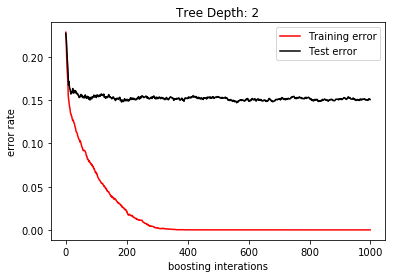

In [11]:
plt.figure()
plt.plot(ada_err_train.mean(axis=0), label="Training error", color="red")
plt.plot(ada_err_test.mean(axis=0), label="Test error", color="black")
plt.ylabel("error rate")
plt.xlabel("boosting interations")
plt.title(f"Tree Depth: {max_depth}")
plt.legend()
plt.show()